In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


from detection.text_detection import TextDetector


In [2]:

# CRNN model 
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(True),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),

            nn.Conv2d(512, 512, 2, 1, 0),
            nn.ReLU(True)
        )

        self.rnn = nn.LSTM(input_size=512, hidden_size=nh, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)             # [B, 512, 1, W]
        conv = conv.squeeze(2)         # [B, 512, W]
        conv = conv.permute(2, 0, 1)   # [W, B, 512]
        recurrent, _ = self.rnn(conv)  # [W, B, nh*2]
        output = self.fc(recurrent)    # [W, B, nclass]
        return output

def ctc_greedy_decoder(output, idx_to_char):
    output = output.permute(1, 0, 2)  # [B, W, nclass]
    decoded_texts = []
    for batch_idx in range(output.shape[0]):
        preds = output[batch_idx]  # [W, nclass]
        pred_indices = torch.argmax(preds, dim=1).cpu().numpy()
        decoded = []
        prev_idx = None
        for idx in pred_indices:
            if idx != 0 and idx != prev_idx:  # skip blank and repeated chars
                decoded.append(idx_to_char.get(idx, ''))
            prev_idx = idx
        decoded_texts.append(''.join(decoded))
    return decoded_texts

def preprocess_crop_for_crnn(crop_img):
    """
    Preprocess crop image for CRNN:
    - Convert to grayscale
    - Resize to (128x32)
    - Normalize [0,1]
    - Convert to tensor [1,1,32,128]
    """
    if len(crop_img.shape) == 3:
        gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = crop_img
    resized = cv2.resize(gray, (128, 32))
    norm = resized.astype('float32') / 255.0
    tensor_img = torch.tensor(norm).unsqueeze(0).unsqueeze(0)  # [1,1,32,128]
    return tensor_img

def sort_crops(crops):
    def sort_key(crop):
        x1, y1, x2, y2 = crop['box']
        return (round(y1 / 10) * 10, x1)
    return sorted(crops, key=sort_key)

def load_vocab(vocab_file):
    with open(vocab_file, 'r', encoding='utf-8') as f:
        chars = [line.strip() for line in f.readlines()]
    return chars


✅ Loaded YOLOv8 model from runs/detect/exp_text_detect3/weights/best.pt

image 1/1 c:\Users\Nitro\Desktop\deeplearningminiproject\testimage.jpg: 224x640 9 handwrittens, 44.7ms
Speed: 1.4ms preprocess, 44.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
Crop 1 predicted text [CRNN]: सेरे


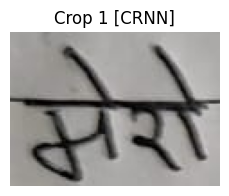

Crop 2 predicted text [CRNN]: आेभ्


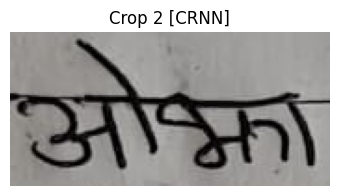

Crop 3 predicted text [CRNN]: नाम


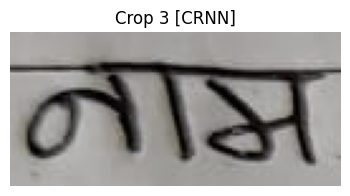

Crop 4 predicted text [CRNN]: टे


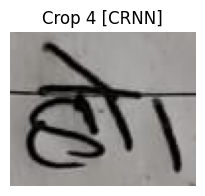

Crop 5 predicted text [CRNN]: हशान


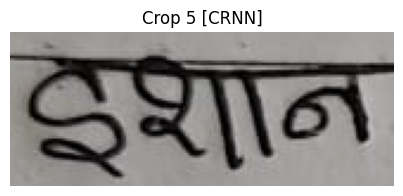

Crop 6 predicted text [CRNN]: काशयपुटर


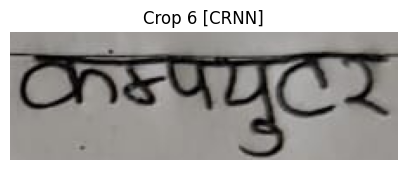

Crop 7 predicted text [CRNN]: ज


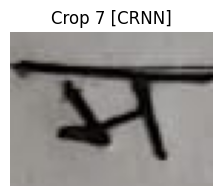

Crop 8 predicted text [CRNN]: सटुन्


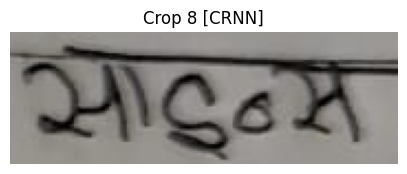

Crop 9 predicted text [CRNN]: पहछ


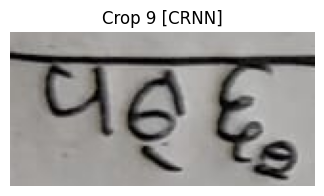


🧾 Full combined predicted text:
सेरे आेभ् नाम टे हशान काशयपुटर ज सटुन् पहछ


In [4]:

def run_ocr_pipeline_crnn_only(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize YOLO detector
    detector = TextDetector(model_path="runs/detect/exp_text_detect3/weights/best.pt")

    # Load charset and CRNN
    charset = load_vocab("vocab.txt")
    idx_to_char = {i: c for i, c in enumerate(charset)}
    nclass = len(charset)
    crnn = CRNN(imgH=32, nc=1, nclass=nclass, nh=256).to(device)
    crnn.load_state_dict(torch.load("tension.pth", map_location=device))
    crnn.eval()

    # Detect crops & boxes
    crops, boxes = detector.predict(image_path, save_crops=False, return_with_boxes=True)
    crops_with_boxes = [{'im': crop, 'box': box} for crop, box in zip(crops, boxes)]

    # Sort crops in reading order
    sorted_crops = sort_crops(crops_with_boxes)

    full_text = ""

    for idx, crop_dict in enumerate(sorted_crops):
        crop_img = crop_dict['im']
        input_tensor = preprocess_crop_for_crnn(crop_img).to(device)

        with torch.no_grad():
            output = crnn(input_tensor)
            crnn_text = ctc_greedy_decoder(output, idx_to_char)[0]

        print(f"Crop {idx+1} predicted text [CRNN]: {crnn_text}")
        full_text += crnn_text + " "

        # Optional: display crop
        rgb_crop = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB) if len(crop_img.shape) == 3 else cv2.cvtColor(crop_img, cv2.COLOR_GRAY2RGB)
        plt.figure(figsize=(5, 2))
        plt.imshow(rgb_crop)
        plt.axis('off')
        plt.title(f"Crop {idx+1} [CRNN]")
        plt.show()

    print("\n🧾 Full combined predicted text:")
    print(full_text.strip())

if __name__ == "__main__":
    run_ocr_pipeline_crnn_only("testimage.jpg")
